In [1]:
import pandas as pd

import numpy as np

from scipy import signal

import matplotlib as mpl
import matplotlib.pyplot as plt

import code

from ajf_bridge_fem import *

import ajf_plts

SEED = ajf_plts.get_seed('gracehill_fe_model.ipynb')

plt.style.use(['./ajf_plts/base.mplstyle'])
#               './ajf_plts/legend_frame.mplstyle'])

# Gracehill Bridge
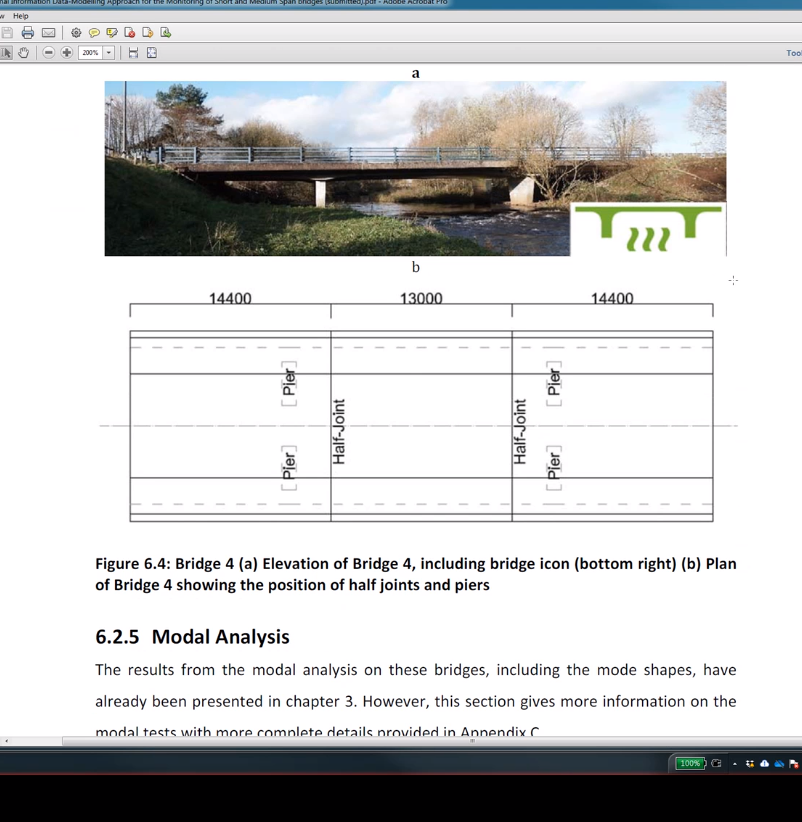

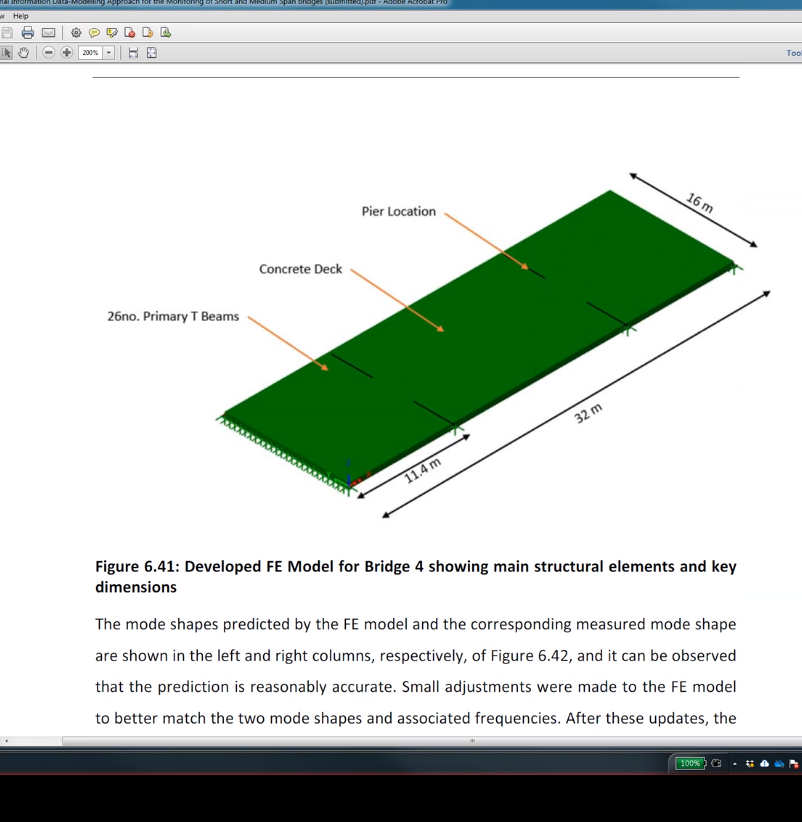

In [218]:
beam = construct_model_GH()

In [219]:
print("bridge_length:", np.sum(beam.L), "m")
print("side_side_length", GH_side_span_length, "m")
print("center_span_length", GH_center_span_length, "m")
print("bridge_width:", beam.area[0]/beam.depth, "m")
print()
print("depth_slab:", beam.depth, "m")
print("area_slab:", beam.area[0], "m^2")
print("I_slab:", beam.I[0], "m^4")

bridge_length: 41.8 m
side_side_length 11.4 m
center_span_length 19.0 m
bridge_width: 8.0 m

depth_slab: 0.65 m
area_slab: 5.2 m^2
I_slab: 0.18308333333333335 m^4


# Modal Test
During the modal test the first mode frequency was found to be 5.54Hz.

Lets check that this comes from a credible E value.

In [220]:
def get_first_mode_freq(E):
    beam.E = E
    beam.update_model()
    return beam.calc_modal_freqs()[0]
v_func = np.vectorize(get_first_mode_freq) 
E_vals = np.linspace(20.0e9, 40e9, 500)
f_vals = v_func(E_vals)

In [221]:
f_modal_test = 5.54 # Hz
E_modal_test = E_vals[np.abs(f_vals - f_modal_test).argmin()] #m * f_modal_test + c
print('f={0:2.2f}Hz => E={1:2.2f}GPa'.format(f_modal_test,E_modal_test/1e9))

f=5.54Hz => E=26.37GPa


In [222]:
beam.E = E_modal_test
beam.update_model()

In [223]:
from scipy import linalg

Mg = beam.Mg
Kg = beam.Kg
evals, evecs = linalg.eigh(Kg, Mg)

freqs = (np.sqrt(evals[evals>=0.0]) / (2.0 * np.pi))
sort_ind = np.argsort(freqs)

mf = len(freqs)

# Mass normalise eigenvectors
QQQ = np.dot(evecs.T,np.dot(Mg,evecs))

for i in range(0, mf):
    nf=np.sqrt(QQQ[i,i])
    for j in range(0,mf):
        evecs[j,i]/=nf

# Sort eigenvectors        
MS = np.zeros((mf,mf))
for i in range(0,mf):
    MS[0:mf,i] = evecs[0:mf,sort_ind[i]]

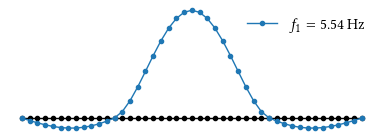

In [224]:
%matplotlib widget
figsize=(0.7*ajf_plts.text_width_inches, 0.7*ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(beam.NODE_X_VALS,
        np.zeros_like(beam.NODE_X_VALS),
        c='k',
        marker='.')
ax.plot(beam.NODE_X_VALS,
        evecs[0:beam.N_BEAM_DOF:2,6]*-1.0, # we only want to plot the displacement mode shape
        ls='-',
        marker='.',
        c='C0',
        label=rf'$f_1=\qty{{{freqs[6]:2.2f}}}{{\hertz}}$')

ax.legend()
ax.axis('off')
fig.tight_layout()
ajf_plts.save_fig(fig, 'figGracehillFEModeShape.pdf')

In [225]:
f_min = 5.27 # Hz
E_f_min = E_vals[np.abs(f_vals - f_min).argmin()]

f_max = 6.16 # Hz
E_f_max = E_vals[np.abs(f_vals - f_max).argmin()]

print(f'f_min: {f_min}Hz -> E={E_f_min/1e9:2.3f}GPa')
print(f'f_max: {f_max}Hz -> E={E_f_max/1e9:2.3f}GPa')

f_min: 5.27Hz -> E=23.888GPa
f_max: 6.16Hz -> E=32.625GPa


# try range of "fixedness"

In [338]:
beam_ss = construct_model_GH()
beam_ss.update_model()

beam_ff = construct_model_GH()
beam_ff.fix_node(beam_ff.x_pos_to_node(0))
beam_ff.fix_node(beam_ff.x_pos_to_node(np.sum(beam_ff.L)))
beam_ff.update_model()

In [339]:
def construct_restrained_model(p, ss, ff):
    beam = construct_model_GH()
    beam.Kg = (1-p/100.0) * ss.Kg + p/100.0 * ff.Kg
    beam.Mg = (1-p/100.0) * ss.Mg + p/100.0 * ff.Mg
    return beam

In [384]:
#res_vals = np.linspace(0, 100, 31, True)
del res_vals, E_vals, f_vals
res_vals = np.linspace(0, 100, 31, True)
res_vals = np.geomspace(0.01, 100, 51, True)
E_vals = np.linspace(20e9, 35e9, 51, True)
f_vals = np.zeros((len(E_vals),len(res_vals)))

for i,E in enumerate(E_vals):
    beam_ss.E = E
    beam_ss.update_model()
    
    beam_ff.E = E
    beam_ff.update_model()
    
    for j,r in enumerate(res_vals):
        b = construct_restrained_model(r, beam_ss, beam_ff)
        f_vals[i,j] = b.calc_modal_freqs()[0 if r < 100.0 else 2]

In [385]:
f_vals.shape, res_vals.shape, E_vals.shape

((51, 51), (51,), (51,))

In [386]:
f_min = 5.27 # Hz
f_max = 6.16 # Hz

f_vals_filt = np.where((f_vals < f_min) + (f_vals > f_max), np.nan, f_vals)

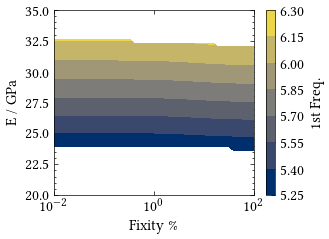

In [387]:
fig, axes = plt.subplots()

plt.contourf(res_vals, E_vals / 1e9, f_vals_filt)

plt.xlabel('Fixity \%')
plt.semilogx()

plt.ylabel('E / GPa')

plt.colorbar().set_label('1st Freq.')


plt.tight_layout()

# try range of springs

In [347]:
res_vals

array([1.00000000e+000, 2.15443469e+003, 4.64158883e+006, 1.00000000e+010,
       2.15443469e+013, 4.64158883e+016, 1.00000000e+020, 2.15443469e+023,
       4.64158883e+026, 1.00000000e+030, 2.15443469e+033, 4.64158883e+036,
       1.00000000e+040, 2.15443469e+043, 4.64158883e+046, 1.00000000e+050,
       2.15443469e+053, 4.64158883e+056, 1.00000000e+060, 2.15443469e+063,
       4.64158883e+066, 1.00000000e+070, 2.15443469e+073, 4.64158883e+076,
       1.00000000e+080, 2.15443469e+083, 4.64158883e+086, 1.00000000e+090,
       2.15443469e+093, 4.64158883e+096, 1.00000000e+100])

In [ ]:
def construct_restrained_model(p, ss):
    beam = construct_model_GH()
    beam.Kg = (1-p/100.0) * ss.Kg + p/100.0 * ff.Kg
    beam.Mg = (1-p/100.0) * ss.Mg + p/100.0 * ff.Mg
    return beam

In [485]:
K_vals = np.geomspace(1e3, 1e20, 51, True)
E_vals = np.linspace(20e9, 35e9, 51, True)
f_vals = np.zeros((len(E_vals),len(K_vals)))

beam = construct_model_GH()

for i,E in enumerate(E_vals):
    beam.E = E
    beam.update_model()
    
    for j,k in enumerate(K_vals):
        del beam.supports[2:]
        beam.add_springdamper_support(beam.x_pos_to_node(0), 0, k, 0, 0)
        k=0.0
        beam.add_springdamper_support(beam.x_pos_to_node(np.sum(beam.L)), 0, k, 0, 0)
        beam.update_model()
        
        f_vals[i,j] = beam.calc_modal_freqs()[0]

In [486]:
f_min = 5.27 # Hz
f_max = 6.16 # Hz

f_vals_filt = np.where((f_vals < f_min) + (f_vals > f_max), np.nan, f_vals)

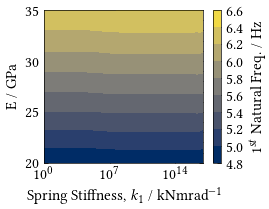

In [487]:
fig, axes = plt.subplots(figsize=(ajf_plts.text_width_inches / 2.0, ajf_plts.fig_height_inches))

plt.contourf(K_vals / 1e3, E_vals / 1e9, f_vals)

plt.xlabel('Spring Stiffness, $k_1$ / kNmrad$^{-1}$')
plt.semilogx()

plt.ylabel('E / GPa')

plt.colorbar().set_label('1$^{st}$ Natural Freq. / Hz')

plt.tight_layout()
ajf_plts.save_fig(fig, 'figGHwRotSpringK2=0.pdf')

In [488]:
beam = construct_model_GH()

for i,E in enumerate(E_vals):
    beam.E = E
    beam.update_model()
    
    for j,k in enumerate(K_vals):
        del beam.supports[2:]
        beam.add_springdamper_support(beam.x_pos_to_node(0), 0, k, 0, 0)
        beam.add_springdamper_support(beam.x_pos_to_node(np.sum(beam.L)), 0, k, 0, 0)
        beam.update_model()
        
        f_vals[i,j] = beam.calc_modal_freqs()[0]

In [489]:
f_min = 5.27 # Hz
f_max = 6.16 # Hz

f_vals_filt = np.where((f_vals < f_min) + (f_vals > f_max), np.nan, f_vals)

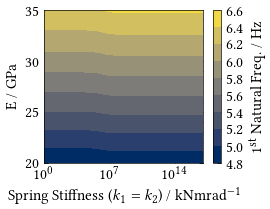

In [490]:
fig, axes = plt.subplots(figsize=(ajf_plts.text_width_inches / 2.0, ajf_plts.fig_height_inches))

plt.contourf(K_vals / 1e3, E_vals / 1e9, f_vals)

plt.xlabel('Spring Stiffness ($k_1=k_2$) / kNmrad$^{-1}$')
plt.semilogx()

plt.ylabel('E / GPa')

plt.colorbar().set_label(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')

plt.tight_layout()
ajf_plts.save_fig(fig, 'figGHwRotSpringK1=K2.pdf')

In [438]:
beam_ss = construct_model_GH()
beam_ss.update_model()

beam_ff = construct_model_GH()
beam_ff.fix_node(beam_ff.x_pos_to_node(0))
beam_ff.fix_node(beam_ff.x_pos_to_node(np.sum(beam_ff.L)))
beam_ff.update_model()

In [439]:
E_vals = np.linspace(20e9, 35e9, 51, True)
ss_f_vals = np.zeros_like(E_vals)
ff_f_vals = np.zeros_like(E_vals)

for i,E in enumerate(E_vals):
    beam_ss.E = E
    beam_ss.update_model()
    
    ss_f_vals[i] = beam_ss.calc_modal_freqs()[0]
    
    beam_ff.E = E
    beam_ff.update_model()
    
    ff_f_vals[i] = beam_ff.calc_modal_freqs()[0]

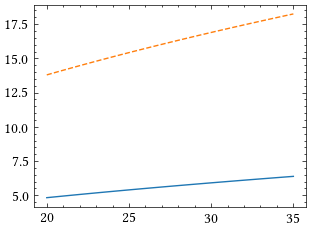

In [443]:
fig, axes = plt.subplots()

plt.plot(E_vals / 1e9, ss_f_vals)
plt.plot(E_vals / 1e9, ff_f_vals)

In [226]:
np.log(np.max(np.abs(beam.Kg[1::2,1::2])) / 1e3)

17.69927670631355

In [245]:
f_min = 5.27 # Hz
f_max = 6.16 # Hz

f_vals = np.linspace(f_min, f_max, 2)
k_vals = np.logspace(15, 20, 20) * 1e3
E_vals = np.linspace(20.0e9, 40e9, 500)

In [246]:
f_vals

array([5.27, 6.16])

In [247]:
E_f_mins = []
E_f_maxs = []
for k in k_vals:
    del beam.supports[2:]
    beam.add_springdamper_support(beam.x_pos_to_node(0), 0, k, 0, 0)
    beam.add_springdamper_support(beam.x_pos_to_node(np.sum(beam.L)), 0, k, 0, 0)
    beam.update_model()
    f_vals = v_func(E_vals)
    E_f_mins.append(E_vals[np.abs(f_vals - f_min).argmin()])
    E_f_maxs.append(E_vals[np.abs(f_vals - f_max).argmin()])

In [248]:
((E_f_mins - E_f_min) / E_f_min) * 100.0

array([ -1.34228188,  -1.34228188,  -1.34228188,  -1.34228188,
        -1.34228188,  -1.34228188,  -1.34228188,  -1.34228188,
        -1.34228188,  -1.51006711,  -1.00671141,  -2.01342282,
        -0.67114094,  -2.34899329,  -4.36241611,  -6.04026846,
         0.67114094,  -1.51006711, -13.9261745 ,  -0.5033557 ])

In [250]:
E_f_mins

[23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23567134268.537075,
 23527054108.21643,
 23647294589.178356,
 23406813627.25451,
 23727454909.81964,
 23326653306.613228,
 22845691382.76553,
 22444889779.55912,
 24048096192.38477,
 23527054108.21643,
 20561122244.48898,
 23767535070.14028]

In [237]:
beam.calc_modal_freqs()

array([6.35306190e+00, 1.68488367e+01, 1.96552322e+01, 2.22041478e+01,
       3.74302490e+01, 5.25767113e+01, 5.42927693e+01, 6.33703825e+01,
       9.20577516e+01, 1.04494049e+02, 1.05025211e+02, 1.26642448e+02,
       1.61037480e+02, 1.67622888e+02, 1.72687492e+02, 2.04740991e+02,
       2.31230557e+02, 2.46585936e+02, 2.69292344e+02, 2.99058534e+02,
       3.26534792e+02, 3.55484168e+02, 3.86640441e+02, 4.17134233e+02,
       4.51814447e+02, 4.89789555e+02, 5.24830237e+02, 5.60947843e+02,
       6.03228711e+02, 6.45596090e+02, 6.86630507e+02, 7.30931445e+02,
       7.76393648e+02, 8.23219518e+02, 8.75567649e+02, 9.24007748e+02,
       9.67909690e+02, 1.02642577e+03, 1.09123915e+03, 1.13247846e+03,
       1.17866233e+03, 1.25348752e+03, 1.30152887e+03, 1.34908418e+03,
       1.38170512e+03, 1.58340309e+03, 1.64409181e+03, 1.64702562e+03,
       1.74452497e+03, 1.91546605e+03, 1.92879881e+03, 1.93352065e+03,
       2.11331922e+03, 2.26383267e+03, 2.26399128e+03, 2.32344721e+03,
      

In [111]:
((E_f_max - E_f_min) / E_f_min) * 100

36.577181208053695

In [114]:
k = 10 ** 9 * 1e3

In [115]:
del beam.supports[2:]
beam.add_springdamper_support(beam.x_pos_to_node(0), 0, k, 0, 0)
beam.add_springdamper_support(beam.x_pos_to_node(np.sum(beam.L)), 0, k, 0, 0)
beam.update_model()

In [217]:
beam.supports

[{'C_lin': array([[0, 0],
        [0, 0]]),
  'C_rot': array([[0, 0],
        [0, 0]]),
  'K_lin': array([[0, 0],
        [0, 0]]),
  'K_rot': array([[ 1000000., -1000000.],
        [-1000000.,  1000000.]]),
  'beam_node': 0},
 {'C_lin': array([[0, 0],
        [0, 0]]),
  'C_rot': array([[0, 0],
        [0, 0]]),
  'K_lin': array([[0, 0],
        [0, 0]]),
  'K_rot': array([[ 1000000., -1000000.],
        [-1000000.,  1000000.]]),
  'beam_node': 44},
 {'C_lin': array([[0, 0],
        [0, 0]]),
  'C_rot': array([[0, 0],
        [0, 0]]),
  'K_lin': array([[0, 0],
        [0, 0]]),
  'K_rot': array([[ 1.e+23, -1.e+23],
        [-1.e+23,  1.e+23]]),
  'beam_node': 0},
 {'C_lin': array([[0, 0],
        [0, 0]]),
  'C_rot': array([[0, 0],
        [0, 0]]),
  'K_lin': array([[0, 0],
        [0, 0]]),
  'K_rot': array([[ 1.e+23, -1.e+23],
        [-1.e+23,  1.e+23]]),
  'beam_node': 44}]

# fitting to range of values

In [129]:
import statsmodels.api as sm

E_vals = np.linspace(1.0e9, 40e9, 500)
f_vals = v_func(E_vals)

f_gh_vals = np.arange(f_min, f_max, 0.05)
E_gh_vals = np.array([E_vals[np.abs(f_vals - f).argmin()] for f in f_gh_vals])

Y = E_gh_vals
X = f_gh_vals
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

/Users/ajf/ajf_conda_envs/jlab/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.951e+04
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           1.46e-27
Time:                        21:37:56   Log-Likelihood:                -347.64
No. Observations:                  18   AIC:                             699.3
Df Residuals:                      16   BIC:                             701.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.777e+10   3.25e+08    -85.540      0.000   -2.85e+10   -2.71e+10
x1           9.78e+09   5.69e+07    171.774      0.000    9.66e+09     9.9e+09
==============================================================================
Omnibus:                        2.099   Durbin-Watson:                   0.493
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.693
Skew:                           0.690   Prob(JB):                        0.429
Kurtosis:                       2.406   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

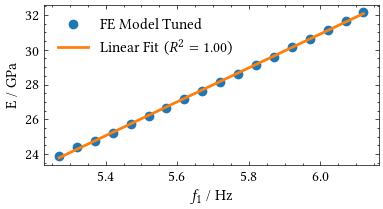

In [130]:
figsize=(0.7*ajf_plts.text_width_inches, ajf_plts.fig_height_inches)

fig, ax = plt.subplots(figsize=figsize)

plt.plot(f_gh_vals, E_gh_vals/1e9, ls='', marker='o', label='FE Model Tuned')
plt.plot(f_gh_vals, results.predict()/1e9, ls='-', lw=2.0, label=f'Linear Fit $(R^2={results.rsquared:1.2f})$')

plt.xlabel('$f_1$ / Hz')
plt.ylabel('E / GPa')
plt.legend()

fig.tight_layout()
ajf_plts.save_fig(fig, 'figFtoEvalFit.pdf')

# save f to E model

In [12]:
results.save('f_to_E_model.pkl')

# save FE model

In [13]:
import pickle

In [14]:
with open('fe_model.pkl', 'wb') as f:
    pickle.dump(dict(side_span_length=side_span_length,
                     center_span_length=center_span_length,
                     construct_model=construct_model),
                f)

NameError: name 'side_span_length' is not defined